# 1.  Display the RSS  values of OWP

Found dataset folders: ['0.15_Speed_OB', '0.15_Speed_withoutOb', '0.275_Speed_OB', '0.275_Speed_withoutOb', '0.45_Speed_OB', '0.45_Speed_withoutOb']

Processing dataset: ../CollectionDataset/0.15_Speed_OB
Original OP data: 20365 rows, Processed OP data: 502 rows

Processing dataset: ../CollectionDataset/0.15_Speed_withoutOb
Original OP data: 24734 rows, Processed OP data: 606 rows

Processing dataset: ../CollectionDataset/0.275_Speed_OB
Original OP data: 20302 rows, Processed OP data: 924 rows

Processing dataset: ../CollectionDataset/0.275_Speed_withoutOb
Original OP data: 15195 rows, Processed OP data: 650 rows

Processing dataset: ../CollectionDataset/0.45_Speed_OB
Original OP data: 13824 rows, Processed OP data: 864 rows

Processing dataset: ../CollectionDataset/0.45_Speed_withoutOb
Original OP data: 19359 rows, Processed OP data: 1178 rows


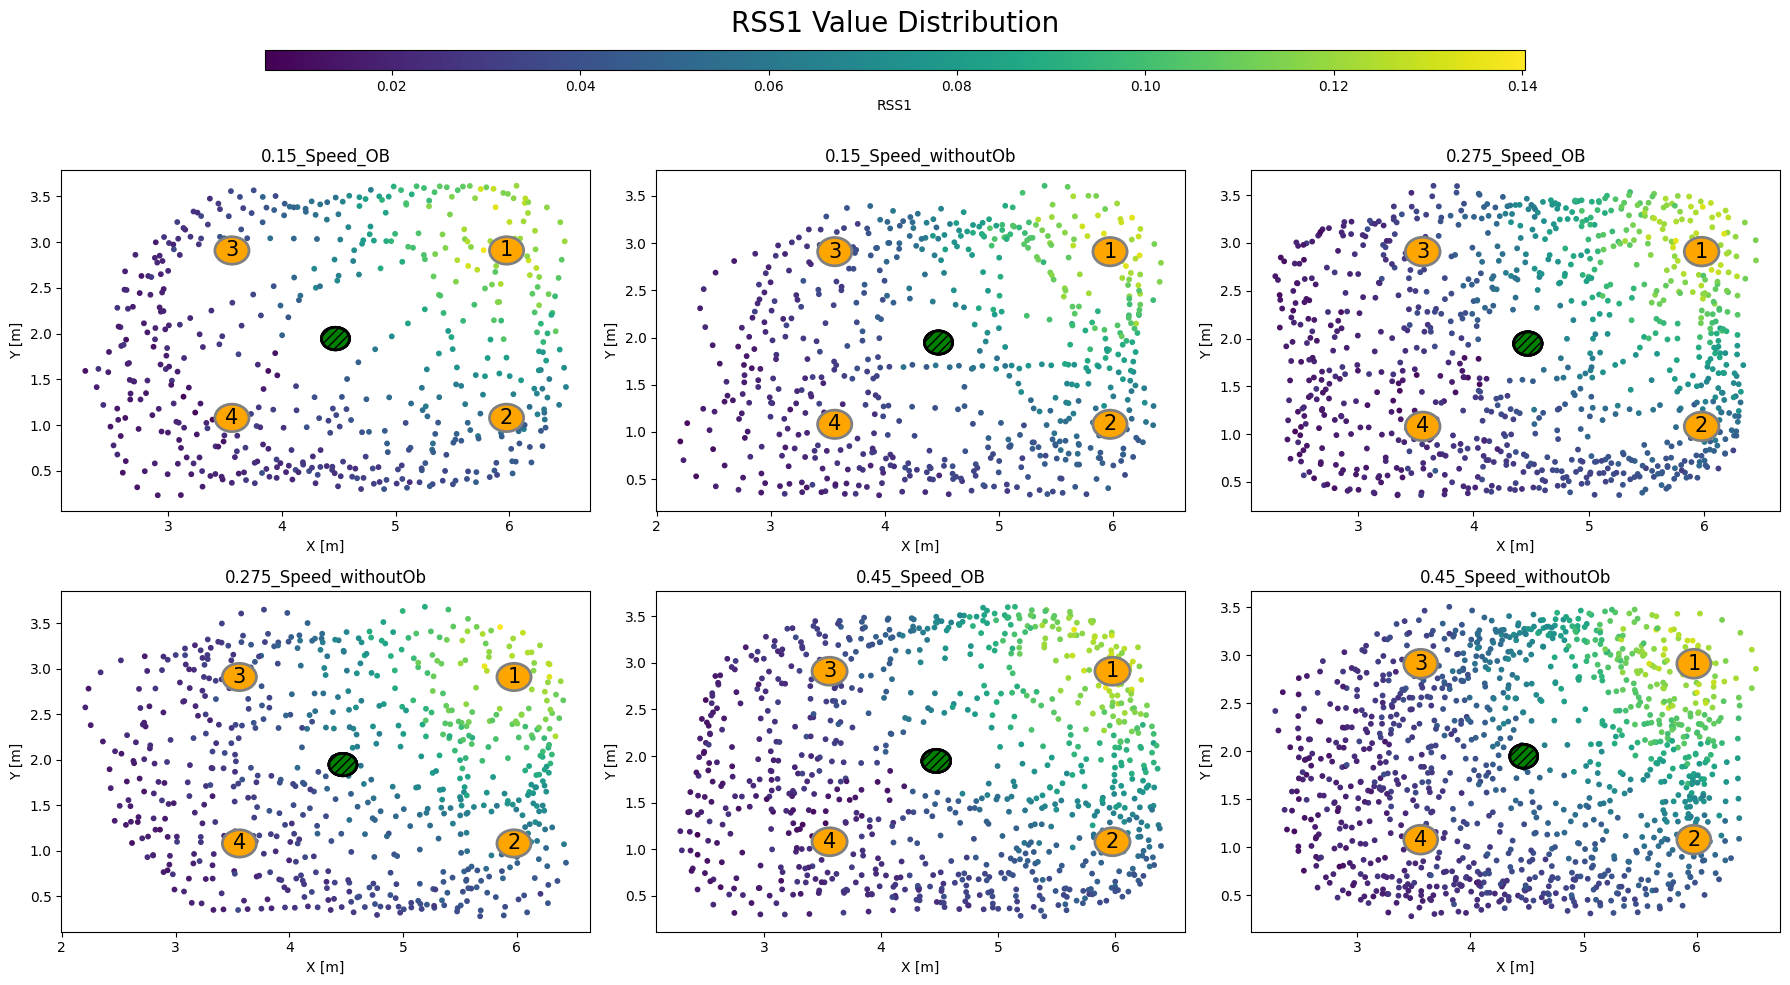

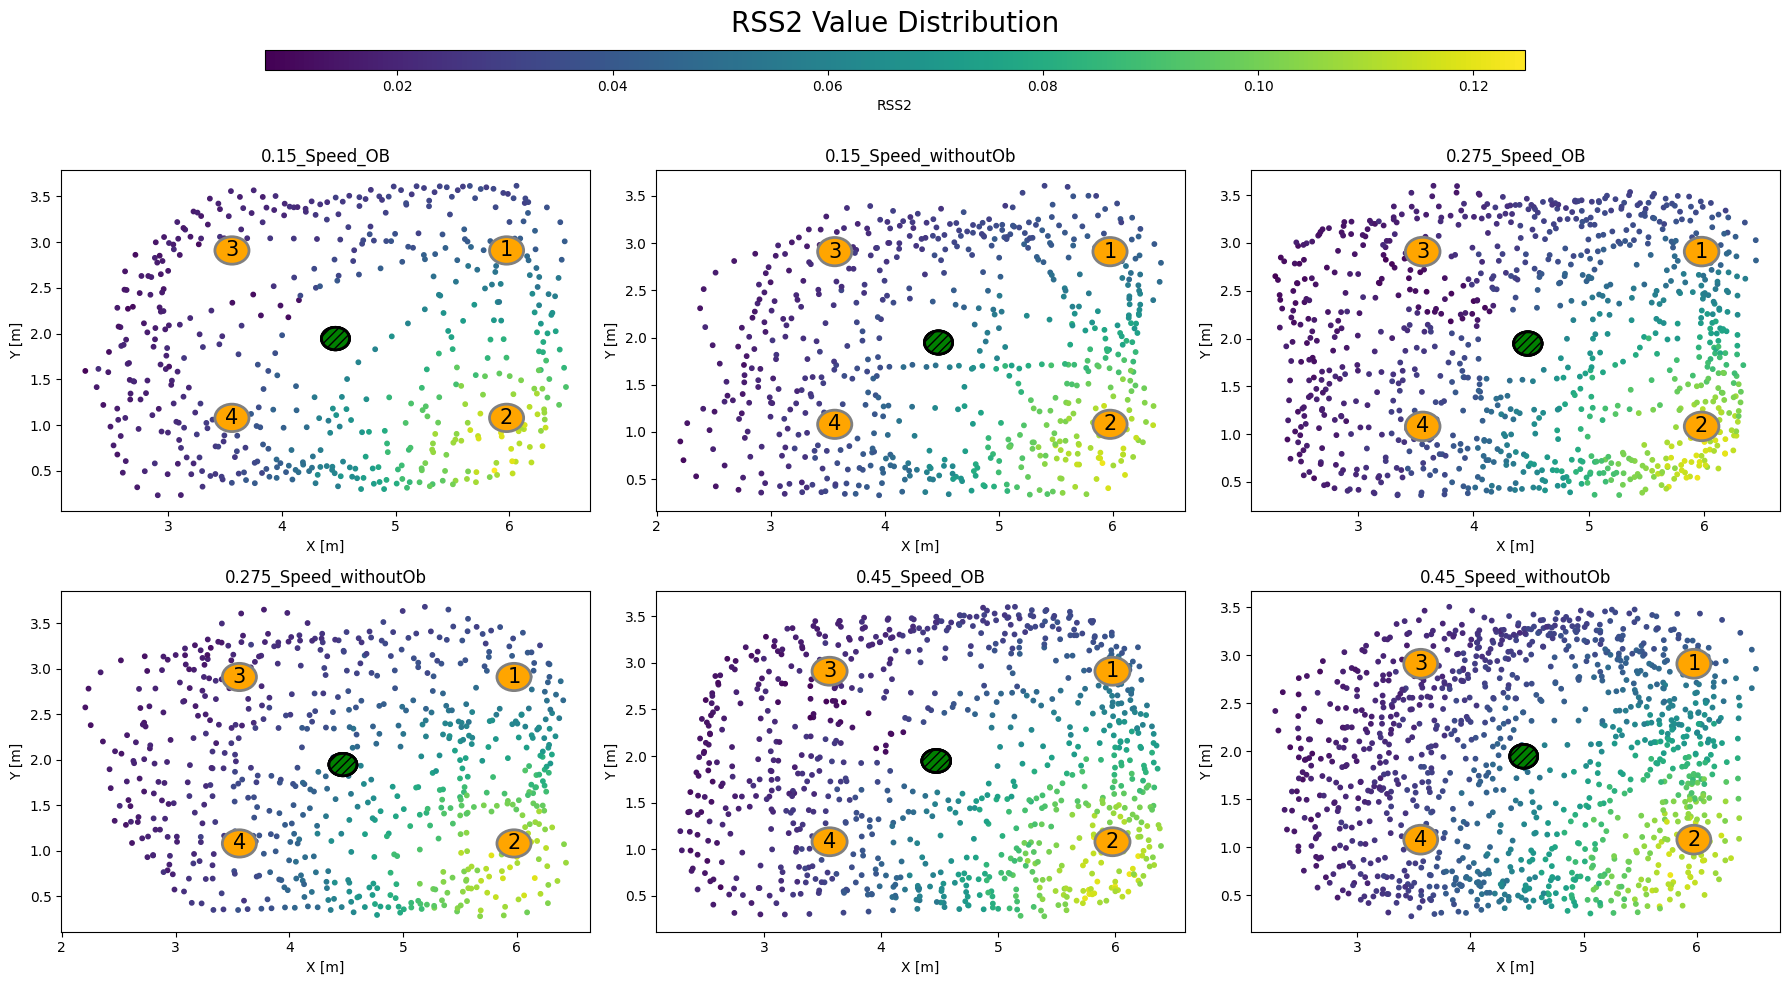

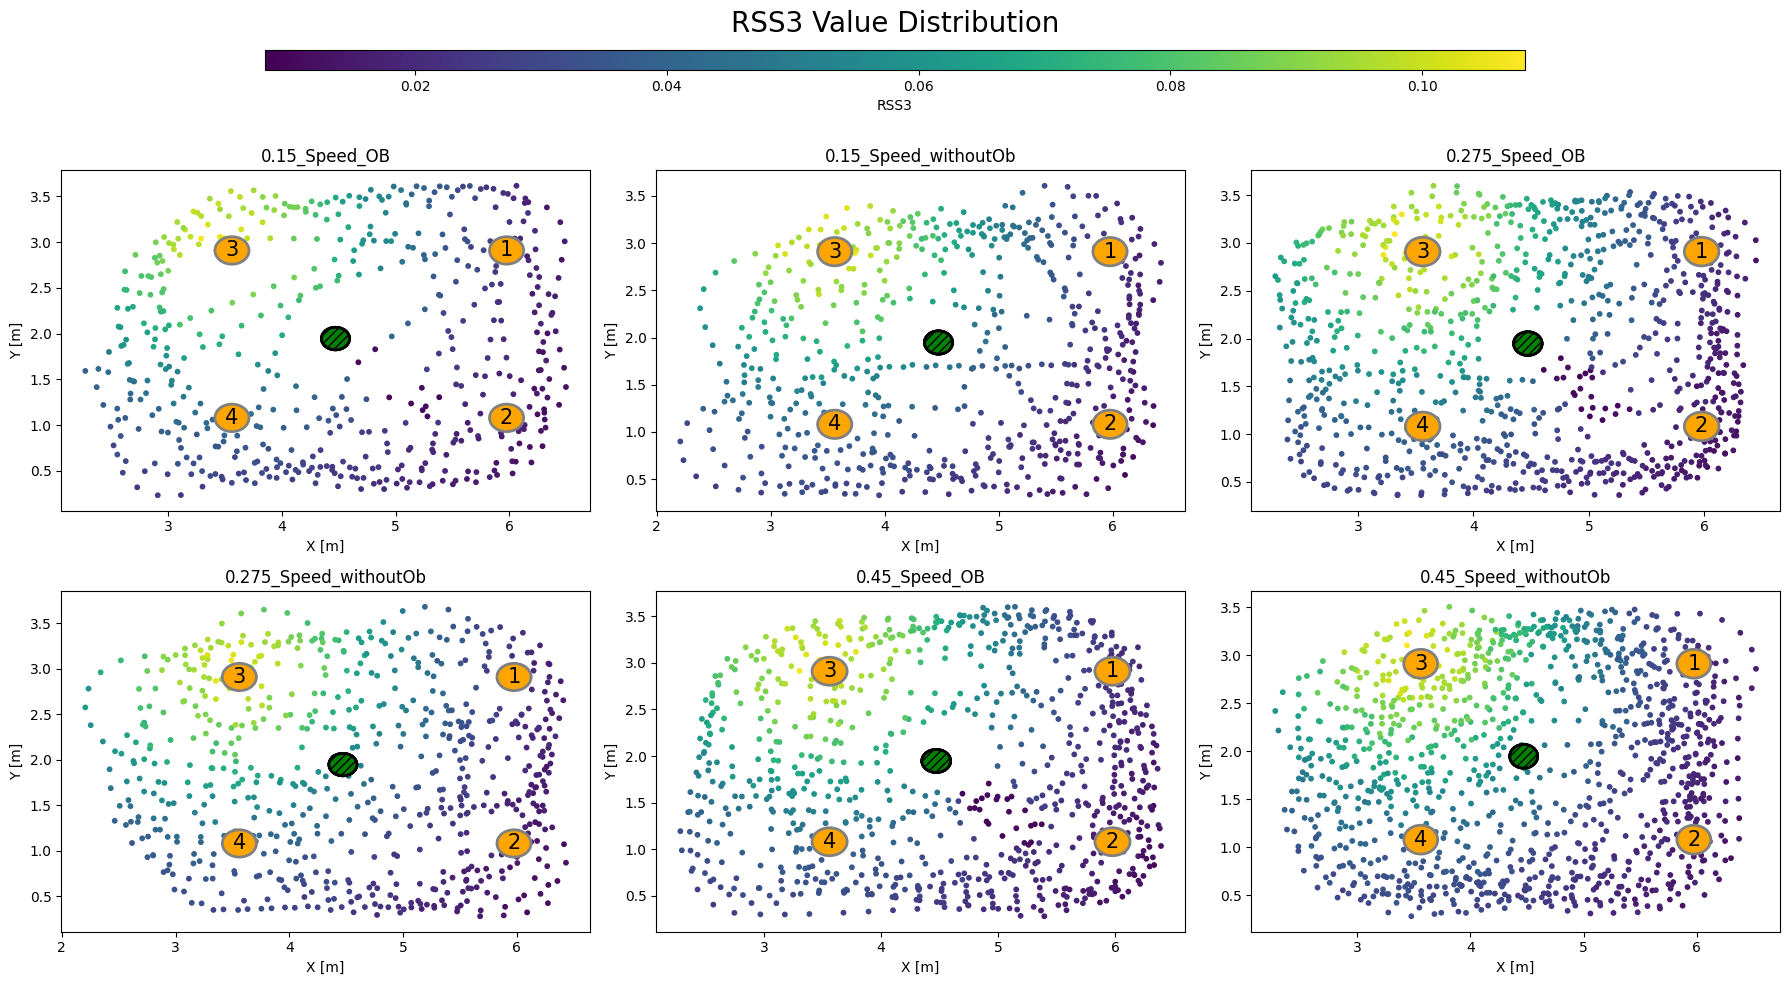

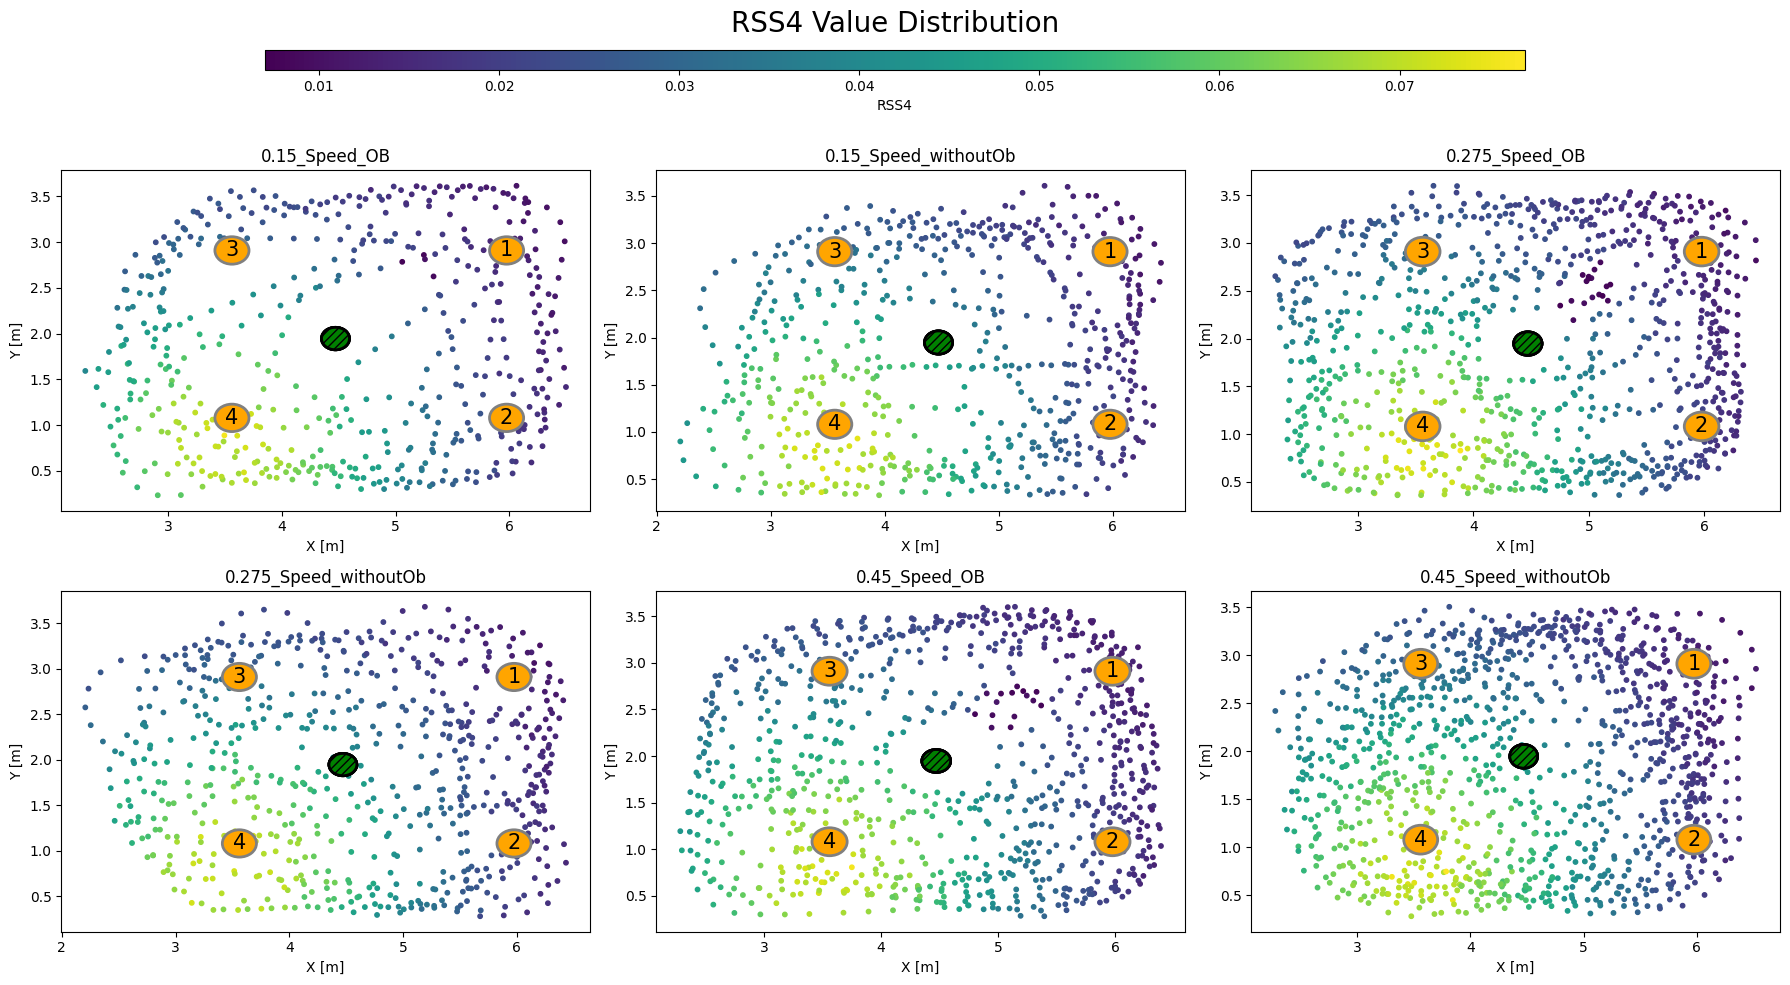

In [7]:
import os
import glob
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from utils import *

# ========== 1. Load all Data ==========
# Set the base dataset path (adjust accordingly)
base_directory = "../CollectionDataset/"

# Get all subfolders (each folder represents a different collection scenario)
dataset_dirs = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
print("Found dataset folders:", dataset_dirs)

data_dict = {} 
for dataset in dataset_dirs:
    dataset_path = os.path.join(base_directory, dataset)
    print(f"\nProcessing dataset: {dataset_path}")
    try:
        # Locate the npy files; take the first file that meets the condition
        gt_npy_path = glob.glob(os.path.join(dataset_path, "*_GT.npy"))[0]
        vlp_npy_path = glob.glob(os.path.join(dataset_path, "*_RSSOWP.npy"))[0]
        imu_npy_path = glob.glob(os.path.join(dataset_path, "*_IMU.npy"))[0]
    except IndexError:
        print(f"Missing required npy files in {dataset_path}, skipping!")
        continue

    # Load data
    gt_data = np.load(gt_npy_path)
    vlp_data = np.load(vlp_npy_path)

    # Preprocess data; expected array format:
    # [gt_ts, op_ts, x, y, z, RSS1, RSS2, RSS3, RSS4]
    processed_data = op_data_preprocessing(gt_data, vlp_data, min_distance_interval=0.2)
    data_dict[dataset] = processed_data

if not data_dict:
    raise ValueError("No processed data found. Please check your paths and data files.")

led_coords = np.array([
    [5.975, 2.910, 2.4],
    [5.975, 1.080, 2.4],
    [3.561, 2.910, 2.4],
    [3.561, 1.080, 2.4]
])


# ========== 2. Plot RSS Values ========== 
rss_channel_indices = [5, 6, 7, 8]  
rss_channel_names   = ["RSS1", "RSS2", "RSS3", "RSS4"]

dataset_names = list(data_dict.keys())
num_subplots = 6  # 2 rows x 3 cols

for rss_idx, channel_name in zip(rss_channel_indices, rss_channel_names):
    # Compute the global min/max for the channel (across all datasets)
    all_values = []
    for ds in dataset_names:
        data = data_dict[ds]
        if data.size > 0:
            all_values.append(data[:, rss_idx])
    if all_values:
        all_values = np.concatenate(all_values)
        global_min = np.min(all_values)
        global_max = np.max(all_values)
    else:
        global_min, global_max = 0, 1

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"{channel_name} Value Distribution", fontsize=20)
    axs_flat = axs.flatten()

    last_sc = None  # Save for colorbar

    for i in range(num_subplots):
        ax = axs_flat[i]
        if i < len(dataset_names):
            ds = dataset_names[i]
            data = data_dict[ds]
            x = data[:, 2]  # x coordinate
            y = data[:, 3]  # y coordinate
            rss_vals = data[:, rss_idx]
            last_sc = ax.scatter(x, y, c=rss_vals, cmap="viridis", vmin=global_min, vmax=global_max, s=10)
            ax.set_title(ds)
        else:
            ax.text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=14)

        ax.set_xlabel("X [m]")
        ax.set_ylabel("Y [m]")


        for idx, led in enumerate(led_coords):
            led_circle = Circle((led[0], led[1]), 0.15, edgecolor='grey', facecolor='orange', lw=2)
            ax.add_patch(led_circle)
            ax.text(led[0], led[1], str(idx + 1), ha='center', va='center', color='black', fontsize=15)

            # Add obstacle if needed
            obstacle_circle = Circle((4.471, 1.947), 0.1225, edgecolor='black', facecolor='green', hatch='////', lw=2)
            ax.add_patch(obstacle_circle)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    cbar_ax = fig.add_axes([0.15, 0.92, 0.7, 0.02])
    fig.colorbar(last_sc, cax=cbar_ax, orientation="horizontal", label=channel_name)
    plt.show()

